In [20]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
# setting up notebook variables
date_chosen = '2025-05-06'

Let's begin by setting up some quick stats on ERCOT and visuals!

In [22]:
# loading in ercot lmp data
# next step will be to set up function to concat all datafiles and output as df here
ercot_data=pl.read_csv(f'datasets/ercot_lmp_data/lmp_node_zone_hub_csv/{date_chosen}_lmp_node_zone_hub.csv')

In [23]:
def transform_ercot_data(ercot_df: object):
    '''
    given ercot df or file, return a transformed verion
    changes scedtimestamp to datetime type...
    '''

    ercot_df = ercot_df.rename(
        {"LMP": "5min_lmp",
         "settlementPoint": "node_id",
         "SCEDTimestamp": "timestamp"
         })
    
    # removing the seconds of ERCOT time stamp, causing issues....
    ercot_df = ercot_df.with_columns(
        pl.col("timestamp").str.replace(r'..$', "00")
    )
    
    ercot_df = ercot_df.with_columns(
        pl.col("timestamp").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S")
    )
    
    ercot_df = ercot_df.with_columns(
        pl.lit("ERCOT").alias("iso_id")
    )

    return ercot_df

In [24]:
# quick info on data set
ercot_data=transform_ercot_data(ercot_df=ercot_data)
ercot_data.describe()

statistic,timestamp,repeatHourFlag,node_id,5min_lmp,iso_id
str,str,f64,str,f64,str
"""count""","""291582""",291582.0,"""291582""",291582.0,"""291582"""
"""null_count""","""0""",0.0,"""0""",0.0,"""0"""
"""mean""","""2025-05-06 11:42:42.680412""",0.0,null,38.23923,null
"""std""",null,null,null,64.982236,null
"""min""","""2025-05-06 00:00:00""",0.0,"""7RNCHSLR_ALL""",-5586.28,"""ERCOT"""
"""25%""","""2025-05-06 05:55:00""",null,null,18.01,null
"""50%""","""2025-05-06 11:45:00""",null,null,23.74,null
"""75%""","""2025-05-06 17:35:00""",null,null,37.52,null
"""max""","""2025-05-06 23:15:00""",0.0,"""ZIER_SLR_ALL""",5624.16,"""ERCOT"""


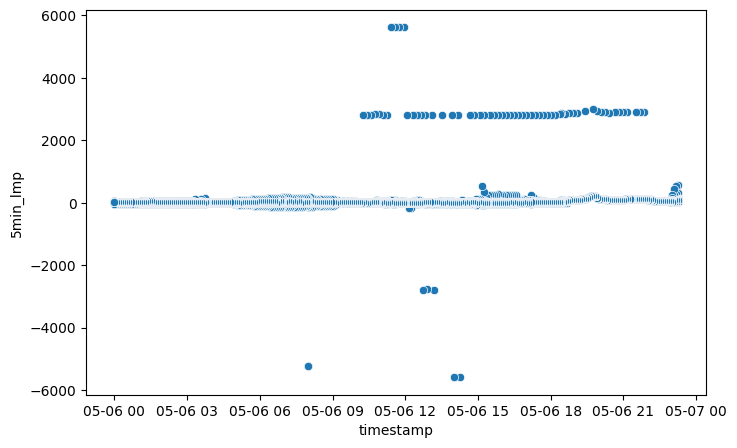

In [27]:
# now let's plot data
plt.figure(figsize=[8,5])

sns.scatterplot(data=ercot_data, x='timestamp', y='5min_lmp')

plt.show()

<Figure size 640x480 with 0 Axes>

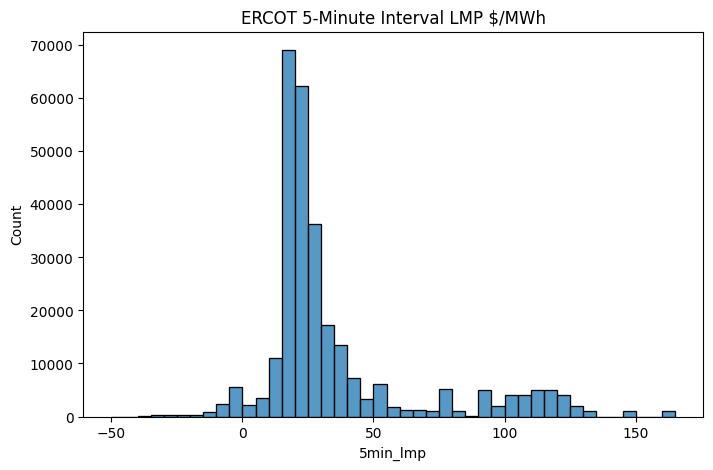

<Figure size 640x480 with 0 Axes>

In [42]:
# lets plot distribution of pricing
plt.figure(figsize=[8,5])

bins=range(-50, 170, 5)
sns.histplot(data=ercot_data, x='5min_lmp', bins=bins, kde=False)

plt.title("ERCOT 5-Minute Interval LMP $/MWh")
plt.figure()